# Word Embeddings Exercises

In these exercises, we'll practice computing word embeddings and using them for sentiment analysis.

- For sentiment analysis, we can go beyond simply counting words.
- Instead, we can represent each word numerically with a vector.
- This vector can capture syntactic (e.g., parts of speech) and semantic (e.g., meaning) structures of words.

We'll explore a classic approach for generating word embeddings, implementing a well-known model called the Continuous Bag of Words (CBOW) model.

By completing this assignment, we will:

- Train word vectors from scratch.
- Understand how backpropagation works.
- Plot and visualize the learned word vectors.

Training these models will deepen our understanding of word vectors, foundational elements in natural language processing and behavior analysis technologies.



#  The Continuous Bag of Words (CBOW) Model

Consider the following sentence: 
> **"I am happy because I am learning."**

- In the Continuous Bag of Words (CBOW) model, we aim to predict the center word using a few surrounding context words.
- For instance, with a context window size of $C = 2$, we would try to predict the word **"happy"** using two words before and two words after the center word:

> $C$ words before: [I, am]  
> $C$ words after: [because, I]  

- This gives us:

$$\text{context} = [I, am, because, I]$$  
$$\text{target} = \text{happy}$$

The model structure is shown below:

<div style="width:image width px; font-size:100%; text-align:center;"><img src='imgs/word2.png' alt="CBOW Model Structure" width="600px" height="250px" /> Figure 1 </div>

In this setup, $\bar x$ represents the average of the one-hot vectors of the context words.

<div style="width:image width px; font-size:100%; text-align:center;"><img src='imgs/mean_vec2.png' alt="Mean Vector" width="600px" height="250px" /> Figure 2 </div>

Once all context words are encoded, we use $\bar x$ as the input to our model.

The architecture you will implement is structured as follows:

\begin{align}
 h &= W_1 \  X + b_1  \tag{1} \\
 a &= ReLU(h)  \tag{2} \\
 z &= W_2 \  a + b_2   \tag{3} \\
 \hat y &= softmax(z)   \tag{4} \\
\end{align}

## Exercise 1 - Data Pre-processing

- **1.1 Read the file `data/shakespeare.txt`. Use the python `open` function for reading the file.**
- **1.2 Remove punctuation and numbers from the text (`,!?;-`).**
- **1.3 Tokenize the text using the `nltk` library.**
- **1.4 Lowercase the tokens and keep only words with alphabetical characters.**

In [1]:
import re
import nltk

with open("data/shakespeare.txt", 'r') as f:
    docs = f.read()

print(f"First 200 lines: {docs[:200]}")
print("---------------")

def preprocess_tokenize(text):
    text = re.sub(r'[,!?;-]', '', text)
    text = nltk.word_tokenize(text)

    return [token.lower() for token in text if token.isalpha()]


data = preprocess_tokenize(docs)
print("Number of tokens:", len(data),'\n', data[:150])

First 200 lines: O for a Muse of fire, that would ascend
The brightest heaven of invention,
A kingdom for a stage, princes to act
And monarchs to behold the swelling scene!
Then should the warlike Harry, like himself,
---------------
Number of tokens: 51631 
 ['o', 'for', 'a', 'muse', 'of', 'fire', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention', 'a', 'kingdom', 'for', 'a', 'stage', 'princes', 'to', 'act', 'and', 'monarchs', 'to', 'behold', 'the', 'swelling', 'scene', 'then', 'should', 'the', 'warlike', 'harry', 'like', 'himself', 'assume', 'the', 'port', 'of', 'mars', 'and', 'at', 'his', 'heels', 'leash', 'in', 'like', 'hounds', 'should', 'famine', 'sword', 'and', 'fire', 'crouch', 'for', 'employment', 'but', 'pardon', 'and', 'gentles', 'all', 'the', 'flat', 'unraised', 'spirits', 'that', 'have', 'dared', 'on', 'this', 'unworthy', 'scaffold', 'to', 'bring', 'forth', 'so', 'great', 'an', 'object', 'can', 'this', 'cockpit', 'hold', 'the', 'vasty', 'fields', 'o

In [2]:
assert len(data) == 51631, f"Error in the data length. Expected 26754 but got {len(data)}"
assert data[3] == 'muse', f"Error: Expected 'muse' but got {data[3]}"
assert data[5] == 'fire', f"Error: Expected 'fire' but got {data[5]}"

## Exercise 2 - Word Frequency

**2. Print the size of the vocabulary and the 10 most frequent tokens.**

In [3]:
from nltk import FreqDist

fdist = FreqDist(data)

print("Size of vocabulary:", len(fdist) )
print("Most frequent tokens:", fdist.most_common(10))

Size of vocabulary: 5966
Most frequent tokens: [('the', 1521), ('and', 1394), ('i', 1271), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 771), ('a', 753), ('you', 748)]


In [4]:
assert len(fdist) == 5966, f"Error: Expected 5841 but got {len(fdist)}"
assert fdist.most_common(1)[0][0] == 'the', f"Error: The most frequent word should be 'the'"

## Exercise 3 - Mapping words to indices and indices to words

3. Create two dictionaries:
    - `word2Ind`: a dictionary that maps words to unique indices.
    - `Ind2word`: a dictionary that maps indices to unique words.

In [5]:
word2Ind = {word: value for value, word in enumerate(fdist.keys())}
Ind2word = {value: word for word, value in word2Ind.items()} 
len(word2Ind), len(Ind2word)

(5966, 5966)

In [6]:
# example of word to index mapping
print("Index of the word 'king' :  ", word2Ind['king'] )
print("Word which has index 2743:  ", Ind2word[2743] )

Index of the word 'king' :   173
Word which has index 2743:   decree


In [7]:
assert word2Ind['king'] == 173, f"Error: The index of the word 'king' should be 173 but got {word2Ind['king']}"
assert Ind2word[2743] == 'decree', f"Error: The word with index 2743 should be 'decree' but got {Ind2word[173]}"

## Exercise 4 - Sliding Window of Words

**4. Implement a function `get_windows(words, C)` that returns a list of tuples, each tuple containing:**
- a center word
- a list of `2*C` context words

In [8]:
def get_windows(words, C):
    i = C

    while i < len(words) - C:
        central_word = words[i]
        before_words = words[i-C:i]
        after_words = words[i+1:i+C+1]

        context_words = before_words + after_words
        yield context_words, central_word

        i += 1

In [9]:
# Print 'context_words' and 'center_word' for the new corpus with a 'context half-size' of 2
for x, y in get_windows(['i', 'am', 'happy', 'because', 'i', 'am', 'learning'], 2):
    print(f'{x}\t{y}')

['i', 'am', 'because', 'i']	happy
['am', 'happy', 'i', 'am']	because
['happy', 'because', 'am', 'learning']	i


In [10]:
assert [x for x in get_windows(['i', 'am', 'happy', 'because', 'i', 'am', 'learning'], 2)] == [(['i', 'am', 'because', 'i'], 'happy'), (['am', 'happy', 'i', 'am'], 'because'), (['happy', 'because', 'am', 'learning'], 'i')], "Error"

## Exercise 5 - One-hot Encoding

**5. Implement a function `word_to_one_hot(word, word2Ind, V)` that gets a word and returns a one-hot encoded vector.**

**Note:** 
- `V` is the size of the vocabulary (the number of words in `word2Ind`).
- `word2Ind` is a dictionary that maps words to indices (created previously).
- The function should return a 1D numpy array with a length equal to the vocabulary size.


In [11]:
import numpy as np

def word_to_one_hot(word, word2Ind, V):
    one_hot = np.zeros(V)
    one_hot[word2Ind[word]] = 1

    return one_hot

In [12]:
# Example
print(word_to_one_hot('muse', word2Ind, len(word2Ind)))

print(sum(word_to_one_hot('muse', word2Ind, len(word2Ind))))

[0. 0. 0. ... 0. 0. 0.]
1.0


In [13]:
assert sum(word_to_one_hot('muse', word2Ind, len(word2Ind))) == 1, f"Error: The sum of the one-hot vector should be 1"
assert len(word_to_one_hot('muse', word2Ind, len(word2Ind))) == 5966 == len(word2Ind), f"Error: The length of the vector should be 5841"

## Exercise 6 - Context Words to One-hot Encoded Vectors

**6. Implement a function `context_words_to_vector(context_words, word2Ind, V)` that returns the average of the one-hot vectors of the words in the context.**

**Note:**
- `context_words` is a list of words (the context words).
- The function should return a 1D numpy array with a length equal to the vocabulary size.

In [14]:
def context_words_to_vector(context_words, word2Ind, V):
    one_hot = [word_to_one_hot(word, word2Ind, V) for word in context_words]

    return np.mean(one_hot, axis=0)

In [15]:
# Example
context_words = list(get_windows(data[:10], 2))[0][0]
print(context_words_to_vector(context_words, word2Ind, len(word2Ind)))

[0.25 0.25 0.   ... 0.   0.   0.  ]


In [16]:
assert sum(context_words_to_vector(context_words, word2Ind, len(word2Ind))) == 1, f"Error: The sum of the vector should be 1"
assert len(context_words_to_vector(context_words, word2Ind, len(word2Ind))) == 5966 == len(word2Ind), f"Error: The length of the vector should be 5841"

## Exercise 7 - Building the Training Set

**7. Implement a function `get_training_example(words, C, word2Ind, V)` that returns the center word one-hot encoded vector and the average of the one-hot vectors of the context words.**

**Note:**
- `words` is a list of words.
- `C` is the context half-size.
- `word2Ind` is a dictionary that maps words to indices.
- `V` is the size of the vocabulary.

In [17]:
def get_training_example(words, C, word2Ind, V):
    for context_word, central_word in get_windows(words, C):
        yield word_to_one_hot(central_word, word2Ind, V), context_words_to_vector(context_word, word2Ind, V)

In [18]:
# Example
for center_word_one_hot, context_words_avg in get_training_example(data[:10], 2, word2Ind, len(word2Ind)):
    print(center_word_one_hot)
    print(context_words_avg)

[0. 0. 1. ... 0. 0. 0.]
[0.25 0.25 0.   ... 0.   0.   0.  ]
[0. 0. 0. ... 0. 0. 0.]
[0.   0.25 0.25 ... 0.   0.   0.  ]
[0. 0. 0. ... 0. 0. 0.]
[0.   0.   0.25 ... 0.   0.   0.  ]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


# Continuous Bag of Words Model

Here is a more complete diagram of the Continuous Bag of Words (CBOW) model:

<div style="width:image width px; font-size:100%; text-align:center;"><img src='imgs/cbow_model_architecture2.png' alt="CBOW Model Structure" width="600px" height="250px" /> Figure 3 </div>

### Let's start by the activation functions:

- **ReLU:** The rectified linear activation function is given by:
$$ ReLU(x) = max(0, x) $$
- **Softmax:** The softmax function is a generalization of the logistic function that "squashes" a K-dimensional vector z of arbitrary real values to a K-dimensional vector $\sigma(z)$ of real values in the range (0, 1) that add up to 1. The function is given by:
$$ \sigma(z)_j = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}} $$

## Exercise 8 - Activation Functions

**8.1 Implement the ReLU activation function.**
- ReLu is used to calculate the values of the hidden layer, in the following way:
$$ z_1 = W_1 \  X + b_1 $$
$$ h = ReLU(z_1) $$

**8.2 Implement the softmax activation function.**
- Softmax is used to calculate the values of the output layer, in the following way:
$$ z_2 = W_2 \  a + b_2 $$
$$ \hat y = softmax(z_2) $$

In [19]:
def ReLU(x):
    return np.maximum(0, x)

In [20]:
# Example
print(ReLU(np.array([1, -1, 0])))

[1 0 0]


In [21]:
assert np.all(ReLU(np.array([1, -1, 0])) == np.array([1, 0, 0])), f"Error: The ReLU function is not correct!"

In [38]:
def softmax(z):
    return (np.exp(z)) / np.sum(np.exp(z)) 

In [23]:
# Example
print(softmax(np.array([1, 2, 3])))

[0.09003057 0.24472847 0.66524096]


In [24]:
assert np.allclose(softmax(np.array([1, 2, 3])), np.array([0.09003057, 0.24472847, 0.66524096])), f"Error: The softmax function is not correct!"
assert np.allclose(np.sum(softmax(np.array([1, 2, 3]))), 1), f"Error: The sum of the softmax function should be 1"

# Trainig the CBOW Model

<img src="imgs/forward.png">

Now that we have implemented the necessary functions to prepare the training data and the activation functions, we can start training the CBOW model.

The model will be trained using the following steps:
1. Initialize the weights and biases.
2. Iterate over the training examples and prepare the input and target output.
3. Calculate the predicted output using the forward pass.
4. Calculate the loss using the predicted output and the target output.
5. Update the weights and biases using backpropagation.
6. Repeat the process for a number of epochs.


## Exercise 9 - Initialize the weights and biases

**9.1 Initialize the weights `W1` and `W2` with random values from a normal distribution using `np.random.randn` with a seed 0.**
- `W1` should be of shape `(N, V)`.
- `W2` should be of shape `(V, N)`.
- `N` is the dimension of the word embedding.
- `V` is the size of the vocabulary.

**9.2 Initialize the biases `b1` and `b2` with zeros.**
- `b1` should be of shape `(N, 1)`.
- `b2` should be of shape `(V, 1)`.

**Note:** Use the same function to initialize the weights and biases. Also, set the seed to 42.


In [25]:
def initialize_model_parameters(V, N, random_seed=42):
    np.random.seed(random_seed)
    W1 = np.random.randn(N, V)
    W2 = np.random.randn(V, N)
    b1 = np.zeros((N, 1))
    b2 = np.zeros((V, 1))

    return W1, W2, b1, b2

In [27]:
# Example
V = len(word2Ind)
N = 10
W1, W2, b1, b2 = initialize_model_parameters(V, N)
print(W1.shape, W2.shape, b1.shape, b2.shape)

(10, 5966) (5966, 10) (10, 1) (5966, 1)


In [28]:
assert W1.shape == (10, 5966), f"Error: The shape of W1 should be (5841, 10) but got {W1.shape}"
assert W2.shape == (5966, 10), f"Error: The shape of W2 should be (10, 5841) but got {W2.shape}"
assert b1.shape == (10, 1), f"Error: The shape of b1 should be (10, 1) but got {b1.shape}"
assert b2.shape == (5966, 1), f"Error: The shape of b2 should be (5841, 1) but got {b2.shape}"

## Exercise 10 - Loss Function (Cross-Entropy)

**10. Implement the cross-entropy loss function.**
- The loss function shoud receive the predicted output `y_hat` and the target output `y`.
- The loss function, cross-entropy, is given by:
$$ J = - \sum_{i=1}^{V} y_i \log(\hat y_i) $$

Where:
- $V$ is the size of the vocabulary.
- $y$ is the one-hot encoded target word.
- $\hat y$ is the predicted output.


In [31]:
def cross_entropy_loss(y, y_hat):
    J = - np.sum(y * np.log(y_hat))
    return J

In [32]:
# Example
y = np.array([1, 0, 0])
y_hat = np.array([0.7, 0.2, 0.1])
print(cross_entropy_loss(y, y_hat))

0.35667494393873245


In [33]:
assert np.allclose(cross_entropy_loss(y, y_hat), 0.35667494393873245), f"Error: The loss is not correct!"

## Exercise 11 - Forward Pass

**11. Implement the forward pass of the CBOW model.**
- The forward pass is given by:
$$ z_1 = W_1 \  X + b_1 $$
$$ h = ReLU(z_1) $$
$$ z_2 = W_2 \  h + b_2 $$
$$ \hat y = softmax(z_2) $$

- The function should return the predicted output $\hat y$.
- The function should also return the hidden layer output $h$.
- The input $X$ is the average of the one-hot vectors of the context words.
- The target output $y$ is the one-hot encoded vector of the center word.
- The weights $W_1$ and $W_2$, and the biases $b_1$ and $b_2$ are the parameters of the model.

In [54]:
def forward_pass(X, W1, W2, b1, b2):
    z1 = np.dot(W1, X) + b1
    h = ReLU(z1)
    z2 = np.dot(W2, h) + b2
    y_hat = softmax(z2)

    return y_hat, h

In [55]:
# Example
training_examples = get_training_example(data, 2, word2Ind, V)
x, y = next(training_examples)

In [56]:
x.shape = (V, 1)
y.shape = (V, 1)
y_hat, h = forward_pass(x, W1, W2, b1, b2)
print(y_hat)

[[5.84213270e-05]
 [1.93369807e-04]
 [8.42189460e-05]
 ...
 [1.79660201e-04]
 [3.94039390e-05]
 [3.11104102e-05]]


In [57]:
assert y_hat.shape == (5966, 1), f"Error: The shape of y_hat should be (5966, 1) but got {y_hat.shape}"

## Exercise 12 - Backward Pass

**12. Implement the backward pass of the CBOW model.**
- The backward pass is used to calculate the gradients of the model parameters.
- The gradients are used to update the weights and biases during training.
- The function should receive the input $X$, the target output $y$, the predicted output $\hat y$, the hidden layer output $h$, and the model parameters $W1$, $W2$, $b1$, and $b2$ and finally the learning rate $\alpha$.
- The function should return the updated weights and biases.

The gradients are calculated as follows:
$$ \frac{\partial J}{\partial z_2} = \hat y - y $$
$$ \frac{\partial J}{\partial W_2} = \frac{\partial J}{\partial z_2} \cdot h^T $$
$$ \frac{\partial J}{\partial b_2} = \frac{\partial J}{\partial z_2} $$
$$ \frac{\partial J}{\partial z_1} = W_2^T \cdot \frac{\partial J}{\partial z_2} \cdot ReLU'(h) $$
$$ \frac{\partial J}{\partial W_1} = \frac{\partial J}{\partial z_1} \cdot X^T $$
$$ \frac{\partial J}{\partial b_1} = \frac{\partial J}{\partial z_1} $$

The weight and bias updates are calculated using the gradients and the learning rate $\alpha$:

$$ W_1 = W_1 - \alpha \cdot \frac{\partial J}{\partial W_1} $$
$$ W_2 = W_2 - \alpha \cdot \frac{\partial J}{\partial W_2} $$
$$ b_1 = b_1 - \alpha \cdot \frac{\partial J}{\partial b_1} $$
$$ b_2 = b_2 - \alpha \cdot \frac{\partial J}{\partial b_2} $$


In [65]:
def backward_pass(X, y, y_hat, h, W1, W2, b1, b2, alpha=0.03):
    dz2 = y_hat-y
    dw2 = np.dot(dz2, h.T)
    db2 = np.sum(dz2, axis=0, keepdims=True)
    dz1 = np.dot(W2.T, dz2) *(h>0)
    dw1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=0, keepdims=True)

    W1 -= alpha*dw1
    W2 -= alpha*dw2
    b1 -= alpha*db1
    b2 -= alpha*db2

    return W1, W2, b1, b2

In [62]:
# Example
V = len(word2Ind)
N = 10
W1, W2, b1, b2 = initialize_model_parameters(V, N)
x, y = next(get_training_example(data, 2, word2Ind, V))
x.shape = (V, 1)
y.shape = (V, 1)
y_hat, h = forward_pass(x, W1, W2, b1, b2)
W1, W2, b1, b2 = backward_pass(x, y, y_hat, h, W1, W2, b1, b2)
print(W1.shape, W2.shape, b1.shape, b2.shape)

(10, 5966) (5966, 10) (10, 1) (5966, 1)


In [63]:
assert W1.shape == (N, V), f"Error: The shape of W1 should be ({N}, {V}) but got {W1.shape}"
assert W2.shape == (V, N), f"Error: The shape of W2 should be ({V}, {N}) but got {W2.shape}"
assert b1.shape == (N, 1), f"Error: The shape of b1 should be ({N}, 1) but got {b1.shape}"
assert b2.shape == (V, 1), f"Error: The shape of b2 should be ({V}, 1) but got {b2.shape}"

## Exercise 13 - Training the CBOW Model with Gradient Descent

**13. Implement the training loop of the CBOW model.**
- The training loop should iterate over the training examples and update the weights and biases using the backward pass.
- Compute the loss at each epoch and print it.
- The function should return the final weights and biases.


In [70]:
def gradient_descent(data, word2Ind, N, alpha, epochs, seed=42):
    V = len(word2Ind)
    W1, W2, b1, b2 = initialize_model_parameters(V, N)

    for epoch in range(epochs):
        training_examples = get_training_example(data, 2, word2Ind, V)
        for x, y in training_examples:
            x.shape = (V, 1)
            y.shape = (V, 1)
            y_hat, h = forward_pass(x, W1, W2, b1, b2)
            W1, W2, b1, b2 = backward_pass(x, y, y_hat, h, W1, W2, b1, b2, alpha)
        
        loss = cross_entropy_loss(y, y_hat)
        print(f"Epoch: {epoch}, Loss: {loss}")

    return W1, W2, b1, b2

In [71]:
# Example
N = 10
alpha = 0.03
epochs = 5
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, alpha, epochs)

Epoch: 0, Loss: 8.693831965074693
Epoch: 1, Loss: 8.693831965074693
Epoch: 2, Loss: 8.693831965074693
Epoch: 3, Loss: 8.693831965074693
Epoch: 4, Loss: 8.693831965074693


## Exercise 14 - Extracting the Word Embeddings

**14. Implement three versions of the function `extract_word_embedding(W1, word, word2Ind)` that returns the word embedding of a given word.**

- 14.1 Extract the embeddings from the weights $W_1$.
- 14.2 Extract the embedding from the weights $W_2$.
- 14.3 Return the average of the two embeddings.

In [72]:
def extract_word_embedding_w1(W1, word, word2Ind):
    idx = word2Ind[word]
    return W1[:, idx]

In [74]:
def extract_word_embedding_w2(W2, word, word2Ind):
    idx = word2Ind[word]
    return W2[idx, :]

In [76]:
def extract_word_embedding_avg(W1, W2, word, word2Ind):

    return (extract_word_embedding_w1(W1, word, word2Ind) + extract_word_embedding_w2(W2, word, word2Ind))/2

In [77]:
# Example
word = 'king'
embedding_w1 = extract_word_embedding_w1(W1, word, word2Ind)
embedding_w2 = extract_word_embedding_w2(W2, word, word2Ind)
embedding_avg = extract_word_embedding_avg(W1, W2, word, word2Ind)
embedding_w1

array([ 0.34115197,  0.95580275, -1.16750082, -0.37372087,  0.27064489,
        0.14966891, -0.5179258 , -0.65786382,  0.70013765, -0.8131994 ])

In [78]:
embedding_w2

array([-1.22979337, -0.15416453,  1.27123241,  0.62361908,  0.52446633,
        0.7472655 ,  0.32489036, -0.33729146,  0.96482857, -0.47585941])

In [79]:
embedding_avg

array([-0.4443207 ,  0.40081911,  0.0518658 ,  0.12494911,  0.39755561,
        0.44846721, -0.09651772, -0.49757764,  0.83248311, -0.6445294 ])

In [80]:
assert embedding_w1.shape == (N,), f"Error: The shape of the embedding should be ({N},) but got {embedding_w1.shape}"
assert embedding_w2.shape == (N,), f"Error: The shape of the embedding should be ({N},) but got {embedding_w2.shape}"
assert embedding_avg.shape == (N,), f"Error: The shape of the embedding should be ({N},) but got {embedding_avg.shape}"

## Exercise 15 - Visualizing the Word Embeddings

**15. Implement a function `plot_word_embeddings(W, word2Ind, words)` that plots the word embeddings of the given words.**

**Note:**
- Use the PCA algorithm to reduce the dimensionality of the embeddings to 2D.
- Use the `scatter` function from `matplotlib.pyplot` to plot the embeddings.

In [102]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_word_embeddings(W, word2Ind, words):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(W.T)
    idx = [word2Ind[word] for word in words]
    plt.scatter(reduced[idx, 0], reduced[idx, 1], c='blue')
    for i in idx:
        plt.text(reduced[i, 0], reduced[i, 1], Ind2word[i])
    plt.show()

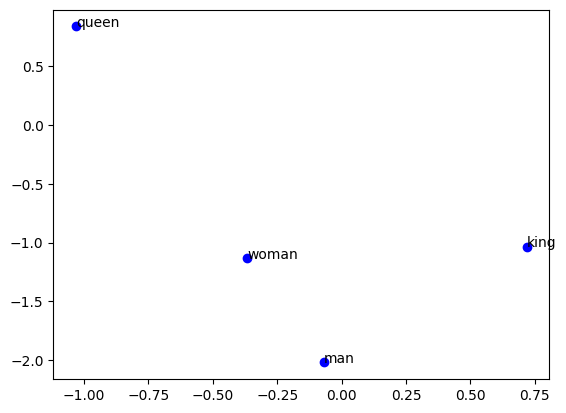

In [103]:
# Example
words = ['king', 'queen', 'man', 'woman']
plot_word_embeddings(W1, word2Ind, words)

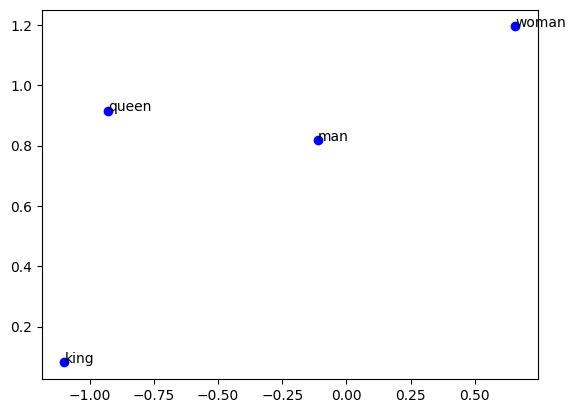

In [89]:
plot_word_embeddings(W2.T, word2Ind, words)

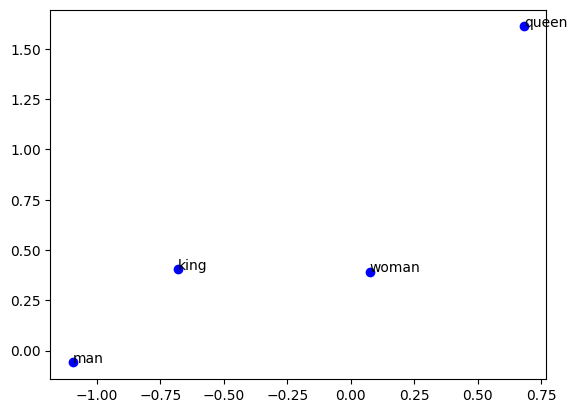

In [90]:
plot_word_embeddings((W1 + W2.T) / 2, word2Ind, words)